# 自动差分引擎

torch.autograd是 PyTorch 的自动差分引擎，可为神经网络训练提供支持。

## 1. 背景

神经网络（NN）是在某些输入数据上执行的嵌套函数的集合。 这些函数由参数（由权重和偏差组成）定义，这些参数在 PyTorch 中存储在张量中。

训练 NN 分为两个步骤：

正向传播：在正向传播中，NN 对正确的输出进行最佳猜测。 它通过其每个函数运行输入数据以进行猜测。

反向传播：在反向传播中，NN 根据其猜测中的误差调整其参数。 它通过从输出向后遍历，收集有关函数参数（梯度）的误差导数并使用梯度下降来优化参数来实现。

## 2. 在PyTorch中的用法

从torchvision加载了经过预训练的 resnet18 模型。 我们创建一个随机数据张量来表示具有 3 个通道的单个图像，高度&宽度为 64，其对应的label初始化为一些随机值。

In [1]:
import torch, torchvision
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

In [2]:
data

tensor([[[[0.0421, 0.5498, 0.7633,  ..., 0.2027, 0.8481, 0.4255],
          [0.0836, 0.1886, 0.6250,  ..., 0.7480, 0.9735, 0.9916],
          [0.5927, 0.5473, 0.0020,  ..., 0.0484, 0.4672, 0.3397],
          ...,
          [0.0417, 0.1756, 0.4057,  ..., 0.6818, 0.5592, 0.0416],
          [0.5929, 0.5567, 0.4616,  ..., 0.7430, 0.3945, 0.5043],
          [0.0605, 0.1436, 0.4877,  ..., 0.3241, 0.3844, 0.1287]],

         [[0.8837, 0.8610, 0.0051,  ..., 0.5536, 0.8028, 0.9089],
          [0.2953, 0.7259, 0.1958,  ..., 0.4079, 0.2951, 0.0619],
          [0.7267, 0.6365, 0.2589,  ..., 0.3394, 0.7242, 0.0889],
          ...,
          [0.8844, 0.3406, 0.3673,  ..., 0.5602, 0.8214, 0.5659],
          [0.0224, 0.1693, 0.6389,  ..., 0.7752, 0.6179, 0.7025],
          [0.0381, 0.5284, 0.7387,  ..., 0.0622, 0.8492, 0.6335]],

         [[0.1731, 0.2461, 0.3651,  ..., 0.5243, 0.4385, 0.5899],
          [0.8973, 0.8928, 0.1662,  ..., 0.8957, 0.8555, 0.4384],
          [0.7018, 0.5639, 0.9140,  ..., 0

接下来，我们通过模型的每一层运行输入数据以进行预测。 这是正向传播。

In [3]:
prediction = model(data) # forward pass

我们使用模型的预测和相应的标签来计算误差（loss）。 下一步是通过网络反向传播此误差。 当我们在误差张量上调用.backward()时，开始反向传播。 然后，Autograd 会为每个模型参数计算梯度并将其存储在参数的.grad属性中。

In [4]:
loss = (prediction - labels).sum()
loss.backward() # backward pass

接下来，我们加载一个优化器，在本例中为 SGD，学习率为 0.01，动量为 0.9。 我们在优化器中注册模型的所有参数。

In [5]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

最后，我们调用.step()启动梯度下降。 优化器通过.grad中存储的梯度来调整每个参数。

In [6]:
optim.step() #gradient descent

In [7]:
optim

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

## 3. autograd的微分

我们用requires_grad=True创建两个张量a和b。 这向autograd发出信号，应跟踪对它们的所有操作。

In [8]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)


我们从a和b创建另一个张量Q。



In [9]:
Q = 3*a**3 - b**2


假设a和b是神经网络的参数，Q是误差。 在 NN 训练中，我们想要相对于参数的误差，即

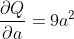

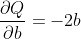

当我们在Q上调用.backward()时，Autograd 将计算这些梯度并将其存储在各个张量的.grad属性中。

我们需要在Q.backward()中显式传递gradient参数，因为它是向量。 gradient是与Q形状相同的张量，它表示Q相对于本身的梯度，即

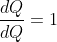

同样，我们也可以将Q聚合为一个标量，然后隐式地向后调用，例如Q.sum().backward()。

In [10]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)


梯度现在沉积在a.grad和b.grad中

In [11]:
a.grad

tensor([36., 81.])

In [12]:
a

tensor([2., 3.], requires_grad=True)

In [13]:
9*a**2

tensor([36., 81.], grad_fn=<MulBackward0>)

In [14]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)


tensor([True, True])
tensor([True, True])
